In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "3" 
import torch
torch.cuda.device_count()

1

In [2]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from glob import glob
# import wandb

import monai
from monai.losses import DiceCELoss, DiceFocalLoss, FocalLoss
from monai.inferers import sliding_window_inference
from monai import transforms

from monai.transforms import (
    AsDiscrete,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    MapTransform,
    ScaleIntensityd,
    #AddChanneld,
    SpatialPadd,
    CenterSpatialCropd,
    EnsureChannelFirstd,
    ConcatItemsd,
    AdjustContrastd, 
    Rand3DElasticd,
    HistogramNormalized,
    NormalizeIntensityd,
    Invertd,
    SaveImage,

)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.nets import SwinUNETR, UNETR, SegResNet

from monai.data import (
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
)
from monai import data


from monai.utils import first, set_determinism
from sklearn.model_selection import train_test_split
import json


import torch

In [3]:
set_determinism(seed=1024)


In [4]:
import os
import json
import random
from glob import glob

def generate_paths(patient_id):
    base_dir = '/home/nada.saadi/MIS-FM/hecktor2022_cropped/data'
    return {
        'id': os.path.join(base_dir, patient_id),
        'ct': os.path.join(base_dir, patient_id, f"{patient_id}_ct.nii.gz"),
        'pt': os.path.join(base_dir, patient_id, f"{patient_id}_pt.nii.gz"),
        'seg': os.path.join(base_dir, patient_id, f"{patient_id}_gt.nii.gz")
    }

# Assign each data entry to a random fold
all_data = []
num_folds = 5
for file_dir in sorted(glob('data/*')):
    patient_id = file_dir.split('/')[-1]
    # Include only MDA files
    if patient_id.startswith("MDA-"):
        entry = generate_paths(patient_id)
        entry['fold'] = random.randint(1, num_folds) - 1
        all_data.append(entry)

# Compile data into a JSON structure
data_json = {"training": all_data}

# Save to JSON file
json_file_path = "/home/nada.saadi/MIS-FM/hecktor2022_cropped/MDA_CTPT_TRAIN.json"
with open(json_file_path, 'w') as f:
    json.dump(data_json, f, indent=4)

print(f"JSON file created at {json_file_path}")


JSON file created at /home/nada.saadi/MIS-FM/hecktor2022_cropped/MDA_CTPT_TRAIN.json


In [5]:
data_dir = '/home/nada.saadi/MIS-FM/hecktor2022_cropped'
json_dir = '/home/nada.saadi/MIS-FM/hecktor2022_cropped/MDA_CTPT_TRAIN.json'

In [6]:
def datafold_read(datalist, basedir, fold=0, key="training"):
    with open(datalist) as f:
        json_data = json.load(f)

    json_data = json_data[key]

    for d in json_data:
        for k in d:
            if isinstance(d[k], list):
                d[k] = [os.path.join(basedir, iv) for iv in d[k]]
            elif isinstance(d[k], str):
                d[k] = os.path.join(basedir, d[k]) if len(d[k]) > 0 else d[k]

    tr = []
    val = []
    for d in json_data:
        if "fold" in d and d["fold"] == fold:
            val.append(d)
        else:
            tr.append(d)

    return tr, val

In [7]:
train_files, validation_files = datafold_read(datalist=json_dir, basedir=data_dir, fold=0)
len(train_files), len(validation_files)

(152, 44)

/home/nada.saadi/miniconda3/envs/clam/lib/python3.8/site-packages/monai/transforms/spatial/array.py:635: UserWarning: axcodes ('RAS') length is smaller than number of input spatial dimensions D=2.
Orientation: spatial shape = (200, 310), channels = 200,please make sure the input is in the channel-first format.
  warnings.warn(


torch.Size([200, 200, 310])


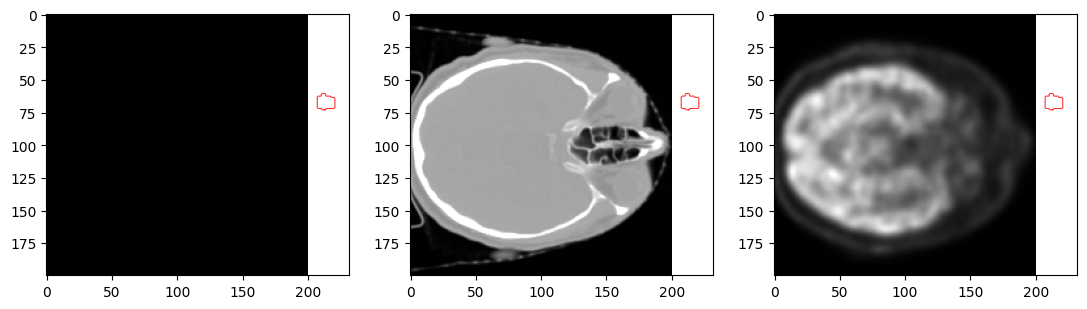

In [5]:
from skimage import measure
import monai
from matplotlib import pyplot as plt
import torch
slice_num = 100
gt = monai.transforms.LoadImage(ensure_channel_first=True)('data/MDA-001/MDA-001_gt.nii.gz')
plt.figure("image", (18, 10))
gt = monai.transforms.Orientation(axcodes='RAS')(gt[0])
plt.subplot(2, 4, 1)
plt.imshow(gt[:,:,slice_num], cmap='gray')
print(gt.shape)

contours = measure.find_contours(gt[:,slice_num,:], 0.5)[0]
plt.plot(contours[:, 1], contours[:, 0], linewidth=0.8, c='red',  alpha = 0.8)

ct = monai.transforms.LoadImage(ensure_channel_first=True)('data/MDA-001/MDA-001_ct.nii.gz')
ct = monai.transforms.Orientation(axcodes='RAS')(ct[0])
ct = torch.clip(ct, min=-1000, max=600)
plt.subplot(2, 4, 2)
plt.imshow(ct[:,:,slice_num], cmap='gray')
plt.plot(contours[:, 1], contours[:, 0], linewidth=0.8, c='red',  alpha = 0.8)

pt = monai.transforms.LoadImage(ensure_channel_first=True)('data/MDA-001/MDA-001_pt.nii.gz')
pt = monai.transforms.Orientation(axcodes='RAS')(pt[0])
plt.subplot(2, 4, 3)
plt.imshow(pt[:,:,slice_num], cmap='gray')
plt.plot(contours[:, 1], contours[:, 0], linewidth=0.8, c='red',  alpha = 0.8)

In [8]:
class ClipCT(MapTransform):
    """
    Convert labels to multi channels based on hecktor classes:
    label 1 is the tumor
    label 2 is the lymph node

    """

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            if key == "ct":
                d[key] = torch.clip(d[key], min=-200, max=200)
            # elif key == "pt":
            #     d[key] = torch.clip(d[key], d[key].min(), 5)
        return d

class MulPTFM(MapTransform):
    """
    Mult PT and FM 

    """

    def __call__(self, data):
        d = dict(data)

        fm = d["ct"] > 0
        d["pt"] = d["pt"] * fm
        return d

class SelectClass(MapTransform):
    """
    Select the class for which you want to fine tune the model 

    """
    # def __init__(self, keys, cls=1):
    #     super(self).__init__(keys)
    #     self.cls = cls

    def __call__(self, data):
        d = dict(data)
        d["seg"][d["seg"] == 1] = 0
        # d["seg"][d["seg"] == 2] = 1
        
        return d

In [9]:
import json
import os

# Assuming 'datalist' and 'data_dir' are defined and contain the correct paths
# Example:
# datalist = '/path/to/your/datalist.json'
# data_dir = '/path/to/your/data/directory'

def datafold_read(datalist, basedir, fold=0, key="training"):
    with open(datalist) as f:
        json_data = json.load(f)

    json_data = json_data[key]

    for d in json_data:
        for k in d:
            if isinstance(d[k], list):
                d[k] = [os.path.join(basedir, iv) for iv in d[k]]
            elif isinstance(d[k], str):
                d[k] = os.path.join(basedir, d[k]) if len(d[k]) > 0 else d[k]

    tr = []
    val = []
    for d in json_data:
        if "fold" in d and d["fold"] == fold:
            val.append(d)
        else:
            tr.append(d)

    return tr, val

# Replace 'json_dir' and 'data_dir' with the actual paths
train_data, valid_data = datafold_read(datalist=json_dir, basedir=data_dir, fold=0)

# Now, save the 'valid_data' to a JSON file 

json_file_path = '/home/nada.saadi/CTPET/hecktor2022_cropped/test_CTPT_only_mda.json'  # Specify the path where you want to save the JSON
with open(json_file_path, 'w') as outfile:
    json.dump(valid_data, outfile, indent=4)

print(f"Validation data saved to {json_file_path}")

Validation data saved to /home/nada.saadi/CTPET/hecktor2022_cropped/test_CTPT_only_mda.json


In [10]:
import json

# Path to your JSON file
json_file_path = '/home/nada.saadi/CTPET/hecktor2022_cropped/test_CTPT_only_mda.json'

# Load the JSON file
with open(json_file_path, 'r') as infile:
    data = json.load(infile)

# Count the number of entries
number_of_files = len(data)

print(f"Number of entries in the JSON file: {number_of_files}")

Number of entries in the JSON file: 44


In [10]:
num_samples = 4

train_transforms = Compose(
    [
        LoadImaged(keys=["ct", "pt", "seg"], ensure_channel_first = True),
        SpatialPadd(keys=["ct", "pt", "seg"], spatial_size=(200, 200, 310), method='end'),
        Orientationd(keys=["ct", "pt", "seg"], axcodes="PLS"),
        NormalizeIntensityd(keys=["pt"]),
        ClipCT(keys=["ct"]),
        ScaleIntensityd(keys=["ct"], minv=0, maxv=1),
        #MulPTFM(keys=["ct","pt"]),
        ConcatItemsd(keys=["pt", "ct"], name="ctpt"),
        #NormalizeIntensityd(keys=["ctpt"], channel_wise=True),
        RandCropByPosNegLabeld(
            keys=["ctpt", "seg"],
            label_key="seg",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=num_samples,
            image_key="ctpt",
            image_threshold=0,
        ),
        RandFlipd(
            keys=["ctpt", "seg"],
            spatial_axis=[0],
            prob=0.20,
        ),
        RandFlipd(
            keys=["ctpt", "seg"],
            spatial_axis=[1],
            prob=0.20,
        ),
        RandFlipd(
            keys=["ctpt", "seg"],
            spatial_axis=[2],
            prob=0.20,
        ),
        RandRotate90d(
            keys=["ctpt", "seg"],
            prob=0.20,
            max_k=3,
        ),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["ct", "pt", "seg"], ensure_channel_first = True),
        SpatialPadd(keys=["ct", "pt", "seg"], spatial_size=(200, 200, 310), method='end'),
        Orientationd(keys=["ct", "pt", "seg"], axcodes="PLS"),
        NormalizeIntensityd(keys=["pt"]),
        ClipCT(keys=["ct"]),
        ScaleIntensityd(keys=["ct"], minv=0, maxv=1),
        #MulPTFM(keys=["ct","pt"]),
        ConcatItemsd(keys=["pt", "ct"], name="ctpt"),
    ]
)

In [11]:
train_ds = monai.data.Dataset(data=train_files, transform=train_transforms)

train_loader = DataLoader(
    train_ds,
    batch_size=2,
    shuffle=True,
    num_workers=8,
    pin_memory=torch.cuda.is_available(),
    )

val_ds = monai.data.Dataset(data=validation_files, transform=val_transforms)

val_loader = DataLoader(
    val_ds, 
    batch_size=2, 
    num_workers=8, 
    shuffle= False)

In [12]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model = SegResNet(in_channels=2, 
#                   out_channels=3, 
#                   init_filters=16).to(device)

model = UNETR(
    in_channels=2,
    out_channels=3,
    img_size=(96, 96, 96),
    feature_size=16, #16
    hidden_size= 768, #768,
    mlp_dim=3072, #3072,
    num_heads=12,
    pos_embed="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0,
).to(device)

# model = SwinUNETR(img_size= (96, 96, 96),
#                   in_channels=2,
#                   out_channels=3,
#                   depths = (2, 2, 2, 2),
#                   num_heads = (3, 6, 12, 24),
#                   feature_size = 24,
#                   norm_name = "instance",
#                   drop_rate = 0.0,
#                 attn_drop_rate = 0.0,
#                 dropout_path_rate = 0.0,
#                 normalize = True,
#                 use_checkpoint = False,
#                 spatial_dims = 3,
#                 downsample="merging").to(device)

/home/nada.saadi/miniconda3/envs/clam/lib/python3.8/site-packages/monai/utils/deprecate_utils.py:221: FutureWarning: monai.networks.nets.unetr UNETR.__init__:pos_embed: Argument `pos_embed` has been deprecated since version 1.2. It will be removed in version 1.4. please use `proj_type` instead.
  warn_deprecated(argname, msg, warning_category)


In [13]:
torch.backends.cudnn.benchmark = True
def poly_lr(epoch, max_epochs, initial_lr, exponent=0.9):
    return initial_lr * (1 - epoch / max_epochs)**exponent

loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [14]:
model_dir = '/home/nada.saadi/MIS-FM/hecktor2022_cropped/MDA_CTPT_unetr_files'

def validation(epoch_iterator_val):
        model.eval()
        with torch.no_grad():
            for step, batch in enumerate(epoch_iterator_val):
                val_inputs, val_labels = (batch["ctpt"].cuda(), batch["seg"].cuda())
                val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)
                val_labels_list = decollate_batch(val_labels)
                val_labels_convert = [
                    post_label(val_label_tensor) for val_label_tensor in val_labels_list
                ]
                val_outputs_list = decollate_batch(val_outputs)
                val_output_convert = [
                    post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list
                ]
                dice_metric(y_pred=val_output_convert, y=val_labels_convert)
                dice_metric_batch(y_pred=val_output_convert, y=val_labels_convert)
                epoch_iterator_val.set_description(
                    "Validate (%d / %d Steps)" % (global_step, 10.0)
                )
            mean_dice_val = dice_metric.aggregate().item()
            metric_batch_val = dice_metric_batch.aggregate()

            metric_tumor = metric_batch_val[0].item()
            metric_lymph = metric_batch_val[1].item()

            dice_metric.reset()
            dice_metric_batch.reset()
        return mean_dice_val, metric_tumor, metric_lymph


def train(global_step, train_loader, dice_val_best, global_step_best):
        model.train()
        epoch_loss = 0
        step = 0
        epoch_iterator = tqdm(
            train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True
        )
        
        for step, batch in enumerate(epoch_iterator):
            step += 1
            x, y = (batch["ctpt"].cuda(), batch["seg"].cuda())
            logit_map = model(x)
            
            loss = loss_function(logit_map, y)
            loss.backward()
            epoch_loss += loss.item()
            optimizer.step()
            optimizer.zero_grad()
            epoch_iterator.set_description(
                "Training (%d / %d Steps) (loss=%2.5f)"
                % (global_step, max_iterations, loss)
            )
            
            if (
                global_step % eval_num == 0 and global_step != 0
            ) or global_step == max_iterations:
                epoch_iterator_val = tqdm(
                    val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True
                )
                dice_val, metric_tumor, metric_lymph = validation(epoch_iterator_val)
                epoch_loss /= step
                epoch_loss_values.append(epoch_loss)
                metric_values.append(dice_val)
                metric_values_tumor.append(metric_tumor)
                metric_values_lymph.append(metric_lymph)
                if dice_val > dice_val_best:
                    dice_val_best = dice_val
                    global_step_best = global_step
                    torch.save(
                        model.state_dict(), os.path.join(model_dir, "best_mda_ctpt_metric_.pth")
                    )
                    print(
                        "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {} Current Avg. tumor Dice: {} Current Avg. lymph Dice: {}".format(
                            dice_val_best, dice_val, metric_tumor, metric_lymph
                        )
                    )
                else:
                    print(
                        "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {} Current Avg. tumor Dice: {} Current Avg. lymph Dice: {}".format(
                            dice_val_best, dice_val,  metric_tumor, metric_lymph
                        )
                    )
            global_step += 1
        return global_step, dice_val_best, global_step_best

       

max_iterations = 18000
eval_num = 100

post_label = AsDiscrete(to_onehot=3)
post_pred = AsDiscrete(argmax=True, to_onehot=3)

dice_metric = DiceMetric(include_background=False, reduction="mean", get_not_nans=False)
dice_metric_batch = DiceMetric(include_background=False, reduction="mean_batch")

epoch = 0
max_num_epochs = 530

global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
metric_values_tumor = []
metric_values_lymph = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(
        global_step, train_loader, dice_val_best, global_step_best
    )
    # wandb.log({'learning_rate': optimizer.param_groups[0]['lr']})
    # wandb.log({'Best Dice': dice_val_best})
    epoch += 1 
    #optimizer.param_groups[0]['lr'] = poly_lr(epoch, max_num_epochs, 0.005676 , 0.9)
# model.load_state_dict(torch.load(os.path.join(model_dir, "best_metric_luck_UNETr_prompt.pth")))

Training (X / X Steps) (loss=X.X):   0%|          | 0/76 [00:00<?, ?it/s]

I;m HEREREEEEEEEEEEEEEEEEEEEEEEE
torch.Size([8, 2, 96, 96, 96])
torch.Size([8, 216, 768])
I;m HEREREEEEEEEEEEEEEEEEEEEEEEE


Training (X / X Steps) (loss=X.X):   0%|          | 0/76 [00:16<?, ?it/s]


KeyboardInterrupt: 